# Comparing a market timing strategy with a savings plan for index investing
The question which I'm trying to answer in this notebooks is
## Can a market timing strategy outperform the monthly savings plan for index investing?
I have been investing into ETFs (in particular the MSCI World ETF) for 2 years now and invested a lot about 2 years ago when the prices were relatively low. As of today (Feb 2020) my MSCI World ETF value is about 30% higher than 2 years ago. Since September 2019 the prices have increased a lot. This made me reluctant to invest in the past 6 months and made me wait for better times with lower prices. But actually the prices kept increasing for months. I would need a drop of 20% for the MSCI World to get to a price that I rejected months ago because it seemed to high to invest at that time. This makes me overthink my strategy, whether it's really a good idea to wait for a good time to invest versus just doing it on a monthly basis no matter what's the current price. 

This is the motivation for a comparison between a monthly savings plan and a market timing strategy. The market timing strategy resembles my investment strategy of the past 2 years. It invests when the drop in price is high. 

* The monthly savings plan invests every month on the first business day of the month the full amount of cash.
* The market timing strategy invests depending on the drop in price compared to the highest price peak within the last 6 months. I chose 6 months since I usually look back 6 months to differentiate between a good or bad time to invest. Further details regarding this strategy will follow below. 

The investment horizon is 20 years because this is my trageted horizon. To achieve a representative result which can be averaged over as many 20 year horizons as possible I require an index with a long history of daily figures. For the MSCI World Index I found daily figures only for the last couple of years. The required figures are available for the S&P 500 since 1927 making 72 20 year slices possible until end of 2019. This is why this index is chosen as basis for this comparison. But only data since 1950 is considered, since the years after 1950 seem more relevant to our current market situation.  

The monthly savings are assumed to be 1000 Dollar. So each month it's possible to invest 1000 Dollar for the savings plan as well as the market timing strategy.

## Spoiler alert: The monthly savings plan can't be outperformed with my strategy
The market timing strategy and even a hybrid between the monthly investment and the market timing strategy can't outperform the monthly savings plan.

But I'm just some Data Scientist with little experience in finance playing around with ideas. My market timing strategy is probably far from perfect, but it does resemble my investment strategy from the past two years and I imagine that many more are investing in that way. I hope to help these people, just like I helped myself, to overcome the burden of trying to find the best time to invest and choose the simple and "boring" way of just investing on a monthly basis. 

## Summary of parameters used for this comparison
monthly_savings = 1000 Dollar

horizon_length = 20 years

etf_idx = '^GSPC' (S&P 500)

In [1]:
import sys
import numpy as np
import pandas as pd
import time
import importlib
try:
    import pandas_datareader as web
except ImportError:
    #!conda install --yes --prefix {sys.prefix} -c anaconda pandas-datareader
    !{sys.executable} -m pip install pandas-datareader
    import pandas_datareader as web
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

import library_functions as lib

pd.set_option('display.max_rows', 100)

In [49]:
importlib.reload(lib);

The parameters of the monthly savings, horizon length and ETF index are set in the following code cell to respectively 1000 Dollar, 20 years and to the S&P 500 index (^GSPC). The price history of this index is pulled from the pandas datareader providing daily figures with High, Low, Open, Close, Volume and Adj Close.

In [3]:
monthly_savings = 1000
horizon_length = 20
# This is the S&P 500 index
etf_idx = '^GSPC'

# dictionary of indices with their respective start and end date
etf_idx_dict = {'^GSPC': '1950-01-01' # S&P 500
               }
start_date, end_date = lib.get_start_and_end_of_history(etf_idx, etf_idx_dict)

# retrieve the data from the pandas-datareader
df_all_data = web.DataReader(etf_idx, 'yahoo', start_date, end_date)

df_all_data['year'] = df_all_data.index.year
df_all_data['month'] = df_all_data.index.month

number_of_horzion_slices = df_all_data.year.iloc[-1]-df_all_data.year.iloc[0]+2-horizon_length

The last 10 rows of the price history of the S&P 500 look as follows

In [4]:
df_all_data.tail(10)

,High,Low,Open,Close,Volume,Adj Close,year,month
Date,,,,,,,,
2019-12-17,3198.219971,3191.030029,3195.399902,3192.520020,3837540000,3192.520020,2019,12
2019-12-18,3198.479980,3191.139893,3195.209961,3191.139893,4014080000,3191.139893,2019,12
2019-12-19,3205.479980,3192.320068,3192.320068,3205.370117,3720450000,3205.370117,2019,12
2019-12-20,3225.649902,3216.030029,3223.330078,3221.219971,6454270000,3221.219971,2019,12
2019-12-23,3227.780029,3222.300049,3226.050049,3224.010010,3060610000,3224.010010,2019,12
2019-12-24,3226.429932,3220.510010,3225.449951,3223.379883,1296540000,3223.379883,2019,12
2019-12-26,3240.080078,3227.199951,3227.199951,3239.909912,2160680000,3239.909912,2019,12
2019-12-27,3247.929932,3234.370117,3247.229980,3240.020020,2428670000,3240.020020,2019,12
2019-12-30,3240.919922,3216.570068,3240.090088,3221.290039,3013290000,3221.290039,2019,12


The maximum and minimum date within this data are 3rd of January 1950 and 31st of December 2019.

In [5]:
df_all_data.reset_index().Date.agg([min, max])

min   1950-01-03
max   2019-12-31
Name: Date, dtype: datetime64[ns]

A moving maximum is computed over a 6 months horizon. For this it needs to be determined what's the average length of 6 months in terms of business days. The following list shows the number of times 6 months consisted of 125, 127 and 126 business days between 1950 and 2019.

In [6]:
df_all_data.groupby(['year', 'month']).size().rolling(6).sum().value_counts().head(3)

125.0    169
127.0    141
126.0    141
dtype: int64

The most common value of number of business days in 6 months seems to be 125 days. This number is taken as window size to determine the maximum price for each window. This operation I call computing the moving max. This will later be the reference point for the percentage drop in the market timing strategy.

In [7]:
number_of_business_days_in_6_months = 125
df_all_data = lib.compute_moving_max(df_all_data, number_of_business_days_in_6_months)
df_all_data_orig = df_all_data.copy()

In the following figure the index history and the times a moving max was updated with a new value are plotted as vertical grey lines:

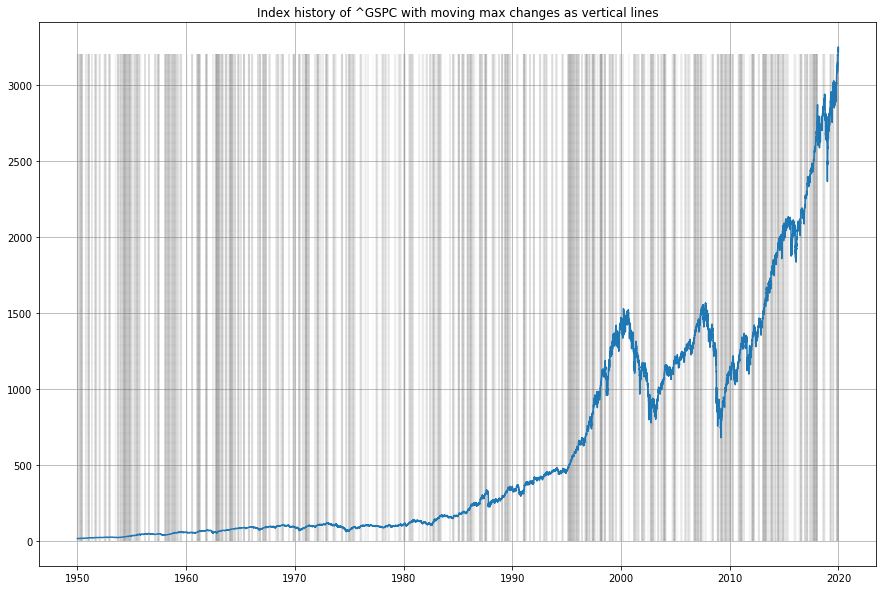

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ymax = np.round(df_all_data.Open.max(), -2)
ymin = 0
vlines = df_all_data.moving_max.drop_duplicates(keep='first')
ax.vlines(vlines.index, ymin, ymax, linewidth=0.1, colors='grey', linestyles='dashed')
ax.plot(df_all_data.Open)
ax.grid()
ax.set_title(f'Index history of {etf_idx} with moving max changes as vertical lines');

## Monthly Savings plan
The monthly savings plan invests each month on the first business day of the month the full amount of available cash. 
According to this monthly savings plan an investment plan is created per 20 year horizon for the 51 20 year horizons between 1950 and 2019. From each investment plan the return of invest is computed for the respective 20 year horizon.

The strategy mode is set to 'monthly_invest_strategy'.

In [11]:
mode = 'monthly_invest_strategy'
roi_per_year_list = []
verbose = 0
for year_start in range(number_of_horzion_slices):
    investment_plan = lib.create_investment_plan(df_all_data,  start_date, year_start, horizon_length, mode, monthly_savings, verbose)
    portfolio_per_year, amount_invested_per_year, win_per_year, roi_per_year = lib.compute_roi(investment_plan)
    roi_per_year_list.append(roi_per_year)
last_investment_plan_monthlyinvest = investment_plan.copy()

The return of invest for each 20 year is are written into a dataframe with the end year of the 20 year horizon as identifier.

In [13]:
rolling_roi_monthlyinvest = pd.DataFrame({'year': [_df.index[-1] for _df in roi_per_year_list], 'roi': [_df.iloc[-1]*100 for _df in roi_per_year_list]})

Take a look at the return of invest over a rolling 20 year horizon in the figure below. The ROI was the highest with a value above 400% in 1998 and 1999. In the investment horizon from 2000 to 2019 it was only around 130. The question I'm asking myself now could the ROI be improved with my market timing strategy? As I haven't been using a monthly savings plan so far I wonder whether I can outperform this strategy by investing at the right time i.e. when the drop in price is high.

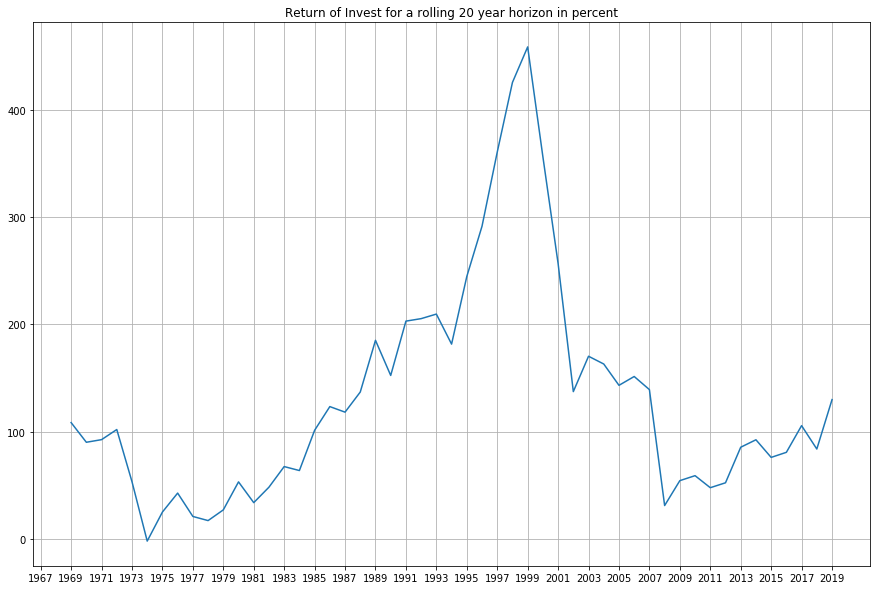

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(rolling_roi_monthlyinvest.set_index('year'))
x_tick_start, x_tick_end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(np.ceil(x_tick_start), np.floor(x_tick_end), 2))
ax.grid()
ax.set_title(f'Return of Invest for a rolling {horizon_length} year horizon in percent');

The average return of invest over all 51 horizons is 130.58%

In [15]:
rolling_roi_monthlyinvest.roi.mean()

130.58097081649245

The figure below depicts all investments during the last 20 year horizon (2000 - 2019). As expected the investment value is always the full amount of cash which is 1000 Dollar in this example.

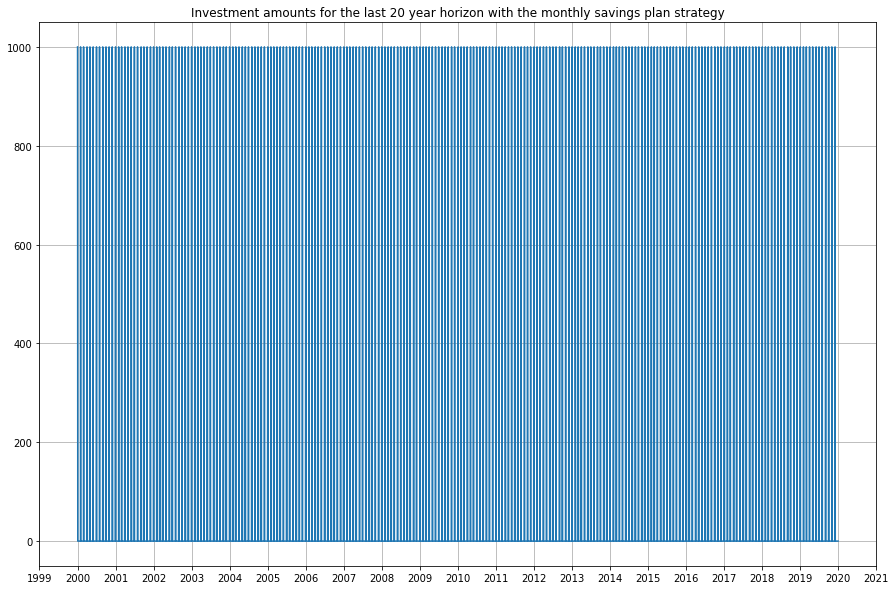

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(last_investment_plan_monthlyinvest.set_index('Date').investment_amount)
x_ticks = lib.get_new_xticks_per_year(last_investment_plan_monthlyinvest)
ax.set_xticks(x_ticks)
ax.grid()
ax.set_title(f'Investment amounts for the last {horizon_length} year horizon with the monthly savings plan strategy');

Return of invest of 130.58% sounds ok but the investment strategy looks a bit boring when taking a look at the above graph. One might think that it shouldn't be to difficult to outperform this boring looking strategy. 

Spoiler alert: Be prepared to be proven wrong. 

## The market timing strategy
Let's have a look at a strategy which invests when the drop in price is high, which sounds like a reasonable strategy to me. 

The market timing strategy invests if the drop in price is below a predefined drop threshold (perc_drop_threshold). Meaning if the drop (in percent) between any adjusted closing price and the maximum price of the last 6 months is larger than the perc_drop_threshold then it is being invested at the next days opening price. The amount of investment is computed as a percentage of the cash available at the time of investment. The larger the drop in price the higher is the percentage of cash invested. To obtain the percentage of cash invested the percentage drop in price is multiplied with the predefiend drop_multiplier. Since the price often stays below the perc_drop_threshold multiple days the variable waiting_days is introduced which models a waiting period between two investments due to drop in price. For example, if waiting_days is 3 then it's possible to invest on the third day since the last investment due to drop in price.

The variables perc_drop_threshold, drop_multiplier, waiting_days are free to choose within their feasible ranges and must be defined before computing the investment plan which models those investment rules. The feasible ranges of the variables are:
* perc_drop_threshold must lie in [0, 1.0]
* waiting_days must lie in [1, inf)
* drop_multiplier must lie in  [1, inf)

In the market timing strategy there is no continuous monthly investment as in the monthly savings plan. Later I will introduce a hybrid strategy which is a combination of the monthly savings plan and the market timing strategy.

In [22]:
mode = 'markettiming_strategy'
roi_per_year_list = []
# invest if the percent_drop is lower than 3.5%
perc_drop_threshold = 0.035
# invest earliest 3 days after the last investment due to drop below 3.5%
waiting_days = 3
# if percent_drop is lower than 3.5% invest 9 times the percent_drop of your cash
drop_multiplier = 9
verbose = 0
start_time = time.time()
for year_start in range(number_of_horzion_slices):
    investment_plan = lib.create_investment_plan(df_all_data, start_date, year_start, horizon_length, mode, monthly_savings, verbose, 
                                             perc_drop_threshold=perc_drop_threshold, waiting_days=waiting_days, drop_multiplier=drop_multiplier)
    portfolio_per_year, amount_invested_per_year, win_per_year, roi_per_year = lib.compute_roi(investment_plan)
    roi_per_year_list.append(roi_per_year)
end_time = time.time()
last_investment_plan_markettiming = investment_plan.copy()
print(f'Computation took {(end_time-start_time):.2f} seconds')

Computation took 132.84 seconds


In [24]:
rolling_roi_markettiming = pd.DataFrame({'year': [_df.index[-1] for _df in roi_per_year_list], 'roi': [_df.iloc[-1]*100 for _df in roi_per_year_list]})

From the following plot it seems like the return of invest in the market timing strategy comes pretty close to the monthly savings plan strategy.

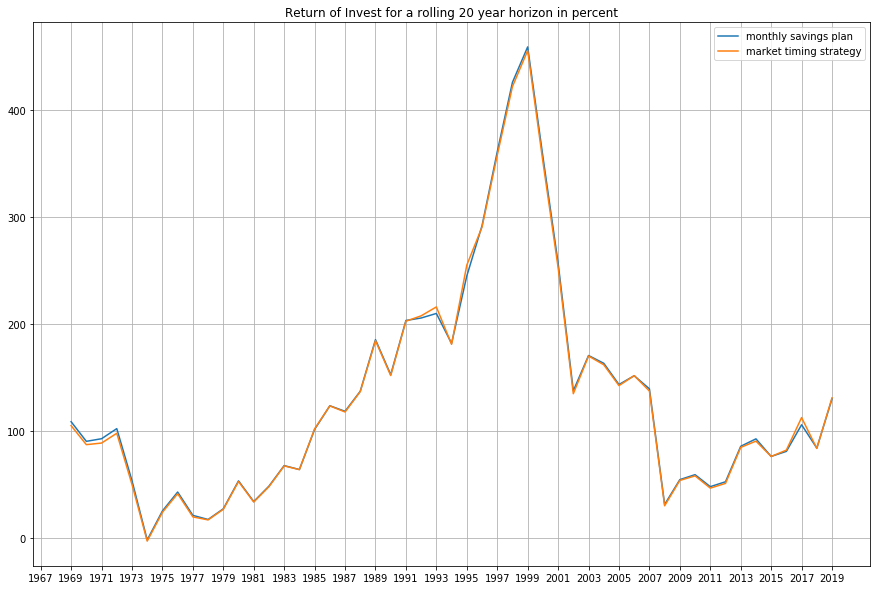

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(rolling_roi_monthlyinvest.set_index('year'), label='monthly savings plan')
ax.plot(rolling_roi_markettiming.set_index('year'), label='market timing strategy')
x_tick_start, x_tick_end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(np.ceil(x_tick_start), np.floor(x_tick_end), 2))
ax.grid()
ax.legend()
ax.set_title(f'Return of Invest for a rolling {horizon_length} year horizon in percent');

Let's have a look at the average ROI over all 20 year horizons and how many times did the market timing strategy outperform the monthly savings plan.

In [26]:
print(f'Monthly savings plan strategy ROI: {rolling_roi_monthlyinvest.roi.mean()}')
print(f'Market timing strategy ROI: {rolling_roi_markettiming.roi.mean()}')

Monthly savings plan strategy ROI: 130.58097081649245
Market timing strategy ROI: 129.76667417675444


In [27]:
print(f'Market timing outperfomed monthly savings plan strategy in {sum(rolling_roi_markettiming.roi>rolling_roi_monthlyinvest.roi)} out of {rolling_roi_monthlyinvest.shape[0]} different {horizon_length} year horizons.')

Market timing outperfomed monthly savings plan strategy in 8 out of 51 different 20 year horizons.


Looks like the average return of invest for the market timing strategy with 129.76% is still a bit below the monthly savings plan ROI with 130.5%. Also the market timing strategy outperformed the monthly savings plan in only 8 out of 51 cases.

Let's have a look at the investment amounts as well as the cash flow of the last 20 year horizon (2000 - 2019).
In 2018 there was one investment of almost 7000 and before that there was no investment for more than 1 year. 

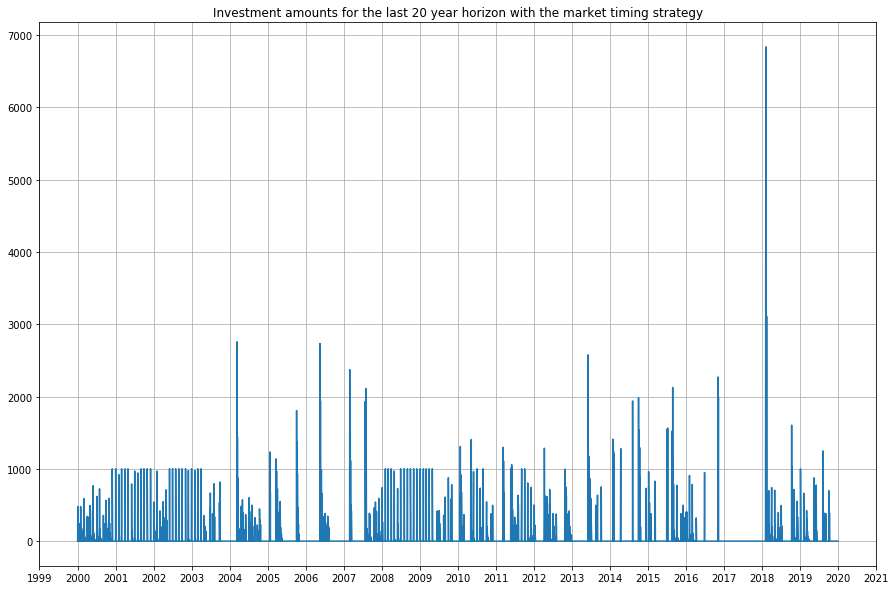

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(last_investment_plan_markettiming.set_index('Date').investment_amount)
x_ticks = lib.get_new_xticks_per_year(last_investment_plan_markettiming)
ax.set_xticks(x_ticks)
ax.grid()
ax.set_title(f'Investment amounts for the last {horizon_length} year horizon with the market timing strategy');

This pause of investment between late 2016 and beginning 2018 is clearly visible in the cashflow. During those months almost 17500 of cash piled up, without any investment. The return of invest could probably have been improved if it was invested on a continuous basis during this time. 

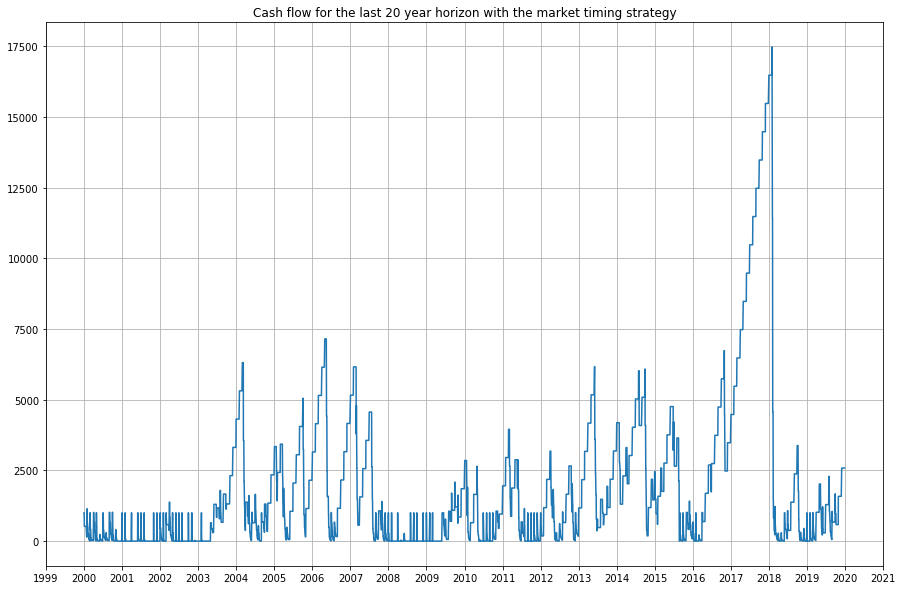

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(last_investment_plan_markettiming.set_index('Date').cash)
x_ticks = lib.get_new_xticks_per_year(last_investment_plan_markettiming)
ax.set_xticks(x_ticks)
ax.grid()
ax.set_title(f'Cash flow for the last {horizon_length} year horizon with the market timing strategy');

This calls for a strategy change. Let's try a hybrid between monthly savings plan and the market timing strategy.

## Hybrid strategy
The hybrid strategy combines the monthly savings plan with the market timing strategy. A percentage (perc_monthly_invest) of the monthly savings is invested at the first business day of each month, the rest is invested according to the market timing strategy.

* The hybrid strategy is equivalent to the monthly savings plan if perc_monthly_invest = 1.0

* The hybrid strategy is equivalent to the market timing strategy if perc_monthly_invest = 0.0 with perc_drop_threshold > 0, waiting_days > 0, drop_multiplier > 0 the same as in the market timing strategy.

In [35]:
mode = 'hybrid_strategy'
roi_per_year_list = []
# invest 90% of monthly cash on a monthly basis
perc_monthly_invest = 0.9
# invest if the percent_drop is lower than 3.5%
perc_drop_threshold = 0.035
# invest earliest 3 days after the last investment due to drop below 3.5%
waiting_days = 3
# if percent_drop is lower than 3.5% invest 9 times the percent_drop of your cash
drop_multiplier = 9
verbose = 0
start_time = time.time()
for year_start in range(number_of_horzion_slices):
    investment_plan = lib.create_investment_plan(df_all_data,  start_date, year_start, horizon_length, mode, monthly_savings, verbose, perc_monthly_invest, 
                                             perc_drop_threshold, waiting_days, drop_multiplier)
    portfolio_per_year, amount_invested_per_year, win_per_year, roi_per_year = lib.compute_roi(investment_plan)
    roi_per_year_list.append(roi_per_year)
end_time = time.time()
last_investment_plan_hybrid = investment_plan.copy()
print(f'Computation took {(end_time-start_time):.2f} seconds')

Computation took 140.69 seconds


In [37]:
rolling_roi_hybrid = pd.DataFrame({'year': [_df.index[-1] for _df in roi_per_year_list], 'roi': [_df.iloc[-1]*100 for _df in roi_per_year_list]})

From the figure below it seems like the hybrid strategy is an improvement to the market timing strategy. It lies very close to the ROI of the monthly savings plan.

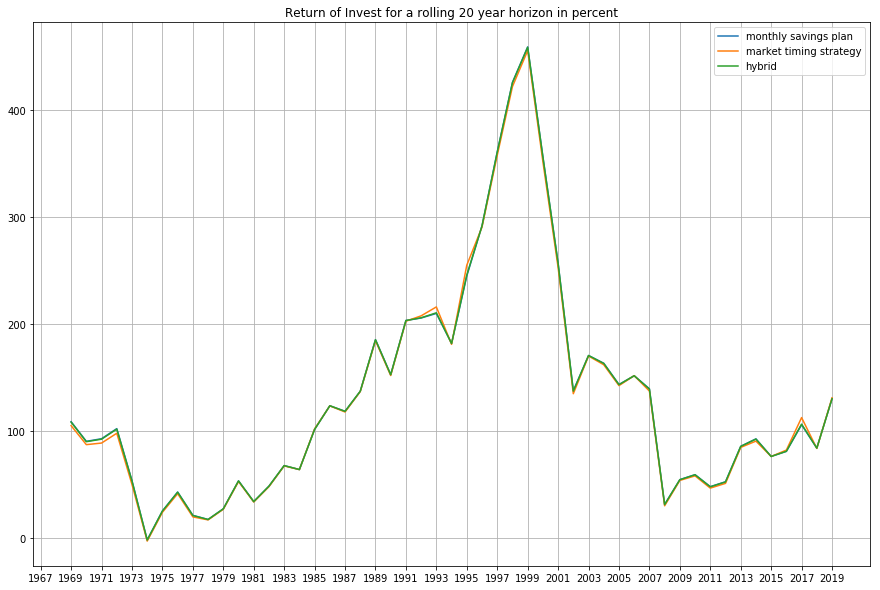

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(rolling_roi_monthlyinvest.set_index('year'), label='monthly savings plan')
ax.plot(rolling_roi_markettiming.set_index('year'), label='market timing strategy')
ax.plot(rolling_roi_hybrid.set_index('year'), label='hybrid')
x_tick_start, x_tick_end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(np.ceil(x_tick_start), np.floor(x_tick_end), 2))
ax.grid()
ax.legend()
ax.set_title(f'Return of Invest for a rolling {horizon_length} year horizon in percent');

Let's have a look at the average return of invest over all 20 year horizons and how many times did the hybrid strategy outperform the monthly savings plan strategy.

In [39]:
print(f'Monthly savings plan strategy ROI: {rolling_roi_monthlyinvest.roi.mean()}')
print(f'Market timing strategy ROI: {rolling_roi_markettiming.roi.mean()}')
print(f'Hybrid strategy ROI: {rolling_roi_hybrid.roi.mean()}')

Monthly savings plan strategy ROI: 130.58097081649245
Market timing strategy ROI: 129.76667417675444
Hybrid strategy ROI: 130.49001402484748


The mean ROI improved from the market timing to hybrid strategy. The hybrid ROI comes now really close to the monthly savings plan ROI with only a difference of 0.08%. But the hybrid strategy still is worse by that amount.

In [40]:
print(f'Hybrid outperfomed monthly savings plan strategy in {sum(rolling_roi_hybrid.roi>rolling_roi_monthlyinvest.roi)} out of {rolling_roi_monthlyinvest.shape[0]} different {horizon_length} year horizons.')
print(f'Market timing outperfomed monthly savings plan strategy in {sum(rolling_roi_markettiming.roi>rolling_roi_monthlyinvest.roi)} out of {rolling_roi_monthlyinvest.shape[0]} different {horizon_length} year horizons.')
print(f'Hybrid outperfomed market timing strategy in {sum(rolling_roi_hybrid.roi>rolling_roi_markettiming.roi)} out of {rolling_roi_monthlyinvest.shape[0]} different {horizon_length} year horizons.')

Hybrid outperfomed monthly savings plan strategy in 8 out of 51 different 20 year horizons.
Market timing outperfomed monthly savings plan strategy in 8 out of 51 different 20 year horizons.
Hybrid outperfomed market timing strategy in 43 out of 51 different 20 year horizons.


The hybrid doesn't outperform the monthly savings plan in more 20 year horizons than the market timing strategy but it seems like per 20 year horizon it got closer to the monthly savings ROI, since the average ROI improved. This becomes evident when looking at how many times did the hybrid outperform the market timing strategy. This is the case in 43 out of 51 cases. So in 43 horizons the hybrid strategy got a better ROI than the market timing strategy. 

Let's have a look at the investment amounts as well as the cash flow of the last 20 year horizon (2000 - 2019). In 2018 there was one investment of 700 and before that there was no investment for more than 1 year. If you remember the same figure from the market timing strategy this sounds very familiar. This investment is about one tenth of the investment of the market timing strategy on exactly the same day.

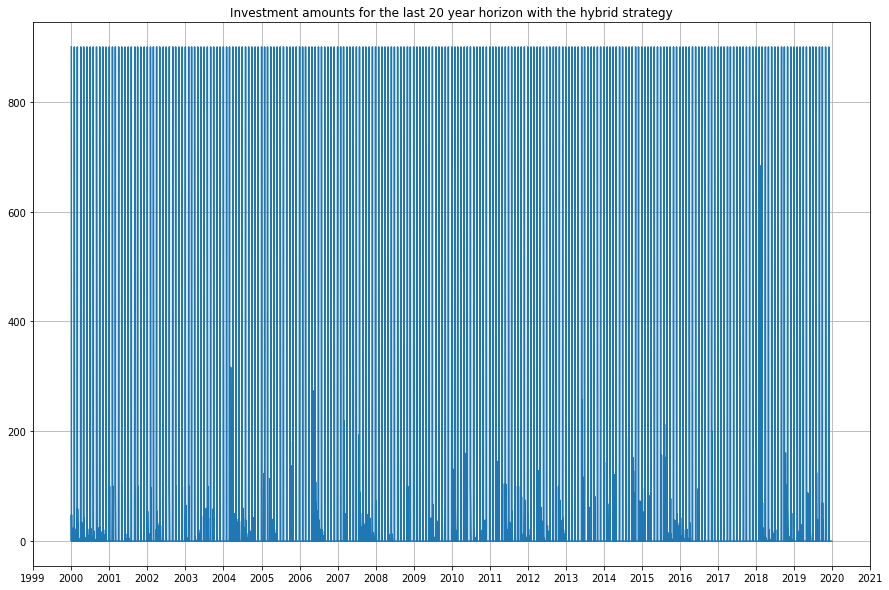

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(last_investment_plan_hybrid.set_index('Date').investment_amount)
x_ticks = lib.get_new_xticks_per_year(last_investment_plan_hybrid)
ax.set_xticks(x_ticks)
ax.grid()
ax.set_title(f'Investment amounts for the last {horizon_length} year horizon with the hybrid strategy');

Also the cash flow looks very similar to the one from the market timing strategy it's just scaled down by about one tenth. 

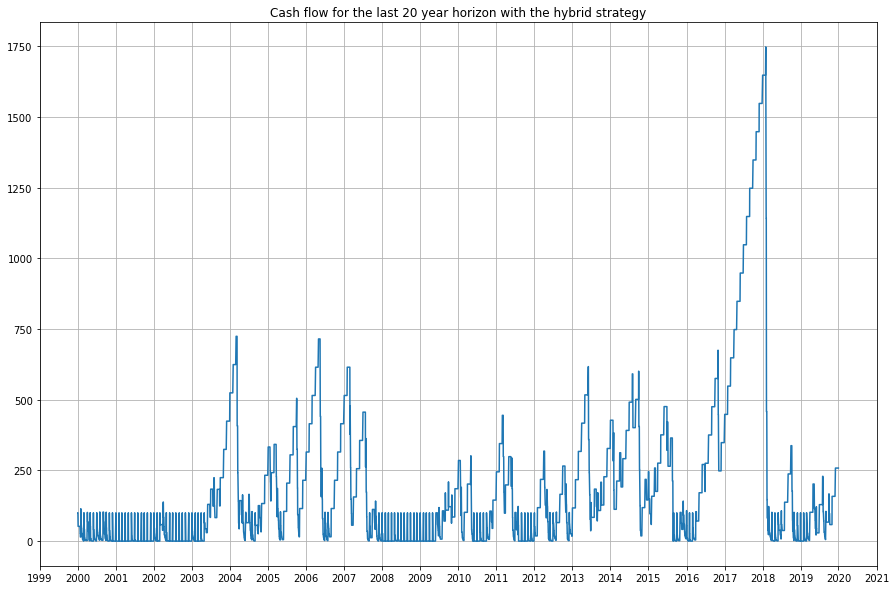

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(last_investment_plan_hybrid.set_index('Date').cash)
x_ticks = lib.get_new_xticks_per_year(last_investment_plan_hybrid)
ax.set_xticks(x_ticks)
ax.grid()
ax.set_title(f'Cash flow for the last {horizon_length} year horizon with the hybrid strategy');

The scaling between the market timing strategy and the hybrid strategy of one tenth matches the fact that in the hybrid strategy only 10% of the cash is available for investment due to drop in price, since 90% is invested on a monthly basis.

## Parameter optimization - Grid Search

The disappointing outcome of this analysis is that the hybrid on average still can't outperform the monthly savings plan strategy. To test whether this is true for all combinations of perc_monthly_invest, perc_drop_threshold, waiting_days, drop_multiplier I ran a grid search over those 4 different parameters assigning the values
* perc_monthly_invest_list = [0.6, 0.7, 0.8, 0.9]
* perc_drop_threshold_list = [0.03, 0.035, 0.04, 0.045, 0.05]
* waiting_days_list = [3, 4, 5, 6, 7, 8]
* drop_multiplier_list = [5, 6, 7, 8, 9]
* mode = 'hybrid_strategy'

this composes a grid out of 600 different combinations which were all run with the hybrid strategy. The result can be read from the file: roi_grid_search_hybrid_strategy.csv

In [43]:
roi_gridsearch_result = pd.read_csv('roi_grid_search_hybrid_strategy.csv')

In [44]:
roi_gridsearch_result = roi_gridsearch_result.sort_values('mean_roi', ascending=False)

After sorting the file by decreasing mean_roi whose first 5 rows are shown in the following table it becomes evident that the parameter combination resulting in the highest mean ROI is 
* perc_monthly_invest = 0.9
* perc_drop_threshold = 0.035
* waiting_days = 3
* drop_multiplier = 9

This is the same which has been used in the previously run market timing strategy example and hybrid strategy example.

In [45]:
roi_gridsearch_result[roi_gridsearch_result.columns[:5]].head()

,drop_multiplier,perc_drop_threshold,waiting_days,perc_monthly_invest,mean_roi
0,9,0.035,3,0.9,130.490014
112,9,0.030,3,0.9,130.485812
113,8,0.035,3,0.9,130.481933
114,8,0.030,3,0.9,130.478262
115,9,0.030,4,0.9,130.473306


## Conclusion

The conclusion is that I can't outperform the monthly savings plan strategy with either my market timing or hybrid strategy. Even though I come close with the hybrid and even if it was possible to outperform it by 1% with one parameter set, the effort needed to evaluate the buy/ no buy decision on a daily basis would be immense. To justify the invested time and effort into evaluting the buy/ no buy decision manually on a daily basis or writing a script which automatically invests based on that strategy I would demand an increase in average ROI by more than 3% i.e. an average ROI of at least 133.5% over 20 year horizons. The desired 3% improvement not only serves to justify the invested time but also provides a savety buffer to the monthly savings plan strategy. This buffer would decrease my anxiety of turning out with less ROI than in the monthly savings plan after 20 years.

Overall I'm impressed with how well the monthly savings plan strategy performs compared to my market timing or hybrid strategy. It looks boring but then again boring means least amount of effort and no buy or no buy decision has to be made which is a relief. As a result I launched my very first monthly savings plan on the MSCI World ETF :-) 

One big caveat for this analysis is: It has been done on the S&P 500. This is of course not the same as the MSCI World index. If I ever get my hands on those daily values from the MSCI World since 1970 I will run this script first thing and find out about the different strategy performances.